<a href="https://colab.research.google.com/github/Ny67130393/Example-Project/blob/main/Durian_Leaf_Decease_Prediction_Narongsak_67130393.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
#@title Restart kenel
!pip -q install -U tqdm

import IPython
IPython.get_ipython().kernel.do_shutdown(True)


{'status': 'ok', 'restart': True}

In [1]:
#@title Reset mark_done
# ป้องกันการจำครั้งก่อน
globals().pop("_blocks_done", None)
print("reset _blocks_done")


reset _blocks_done


In [ ]:
# Persist checkpoints to Google Drive
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

CKPT_DIR = Path('/content/drive/MyDrive/durian_leaf_ckpts')  # เปลี่ยนชื่อโฟลเดอร์ได้
CKPT_DIR.mkdir(parents=True, exist_ok=True)
print("Checkpoint dir:", CKPT_DIR)


In [2]:
#@title ตรวจสอบว่าแต่ละบล็อกทำงานแล้วหรือยัง (พร้อมแสดงสถานะทันที)

from datetime import datetime

def _get_done():
    return sorted(globals().get("_blocks_done", set()))

def show_done():
    """แสดงรายการบล็อกที่ถูก mark แล้ว"""
    done = _get_done()
    if not done:
        print("ℹ️ ยังไม่มีบล็อกที่ถูกทำเครื่องหมายว่าเสร็จ")
    else:
        print(f"✅ บล็อกที่ทำแล้ว ({len(done)}): " + " , ".join(done))

def reset_done(*names):
    """ล้างสถานะทั้งหมด หรือเฉพาะชื่อที่ระบุ"""
    if "_blocks_done" not in globals():
        print("ℹ️ ยังไม่มีสถานะให้ล้าง"); return
    if names:
        for n in names:
            globals()["_blocks_done"].discard(n)
        print("🧹 ล้างสถานะเฉพาะ:", ", ".join(names))
    else:
        globals().pop("_blocks_done", None)
        print("🧹 ล้างสถานะทั้งหมดเรียบร้อย")

def mark_done(name: str):
    """ทำเครื่องหมายว่าบล็อกนี้รันเสร็จ"""
    done = globals().setdefault("_blocks_done", set())
    done.add(name)
    print(f"[done] {name} ✓   all_done = {sorted(done)}")

def check_done(*names):
    """ตรวจว่าบล็อกก่อนหน้าถูกทำเสร็จครบหรือยัง"""
    done = globals().get("_blocks_done", set())
    missing = [n for n in names if n not in done]
    if missing:
        raise RuntimeError("กรุณารันบล็อกก่อนหน้าให้ครบก่อน: " + " → ".join(missing))

def require_vars(*names):
    """ตรวจว่าตัวแปรจำเป็นถูกประกาศแล้วหรือยัง"""
    missing = [n for n in names if n not in globals()]
    if missing:
        raise RuntimeError("ขาดตัวแปร (น่าจะยังไม่ได้รันบล็อกก่อนหน้า): " + ", ".join(missing))

# แสดงผลทันทีเมื่อรันเซลล์นี้
print(f"[utils ready @ {datetime.now().strftime('%H:%M:%S')}]")
show_done()


[utils ready @ 16:32:08]
ℹ️ ยังไม่มีบล็อกที่ถูกทำเครื่องหมายว่าเสร็จ


In [4]:
#@title ขั้นตอนที่ 1: ติดตั้งไลบรารีและนำเข้าโมดูล
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 || true
!pip -q install scikit-learn || true
# !pip -q install timm  # ปลดล็อคถ้าต้องการใช้งาน EfficientNet

import os, zipfile, math, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import torchvision
from torchvision import transforms as T, models
from sklearn.metrics import classification_report, confusion_matrix

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print('Torch', torch.__version__, 'CUDA', torch.cuda.is_available())



Torch 2.8.0+cu126 CUDA True


In [5]:
#@title ขั้นตอนที่ 2: เลือกแหล่งข้อมูล SOURCE = Upload หรือ Google Drive หรือ gdown
SOURCE = "gdown"  #@param ["upload", "gdrive", "gdown"]

from pathlib import Path
import zipfile

BASE = Path('Durian_Leaf_Decease_Prediction'); BASE.mkdir(exist_ok=True)

def smart_extract(zip_path, out_dir):
    out_dir.mkdir(exist_ok=True)
    with zipfile.ZipFile(zip_path,'r') as z: z.extractall(out_dir)
    kids=[k for k in out_dir.iterdir() if k.is_dir()]
    if len(kids)==1 and all(not (p.name.lower() in {'train','test_1','test_2'}) for p in kids[0].iterdir() if p.is_dir()):
        sub=kids[0]
        for it in sub.iterdir(): it.rename(out_dir/it.name)
        try: sub.rmdir()
        except: pass

if SOURCE=="upload":
    from google.colab import files
    print("อัปโหลด train.zip, test_1.zip, test_2.zip")
    up = files.upload()  # เลือกไฟล์ทั้งสาม
    TRAIN_ZIP = [k for k in up if 'train' in k.lower()][0]
    TEST1_ZIP = [k for k in up if 'test_1' in k.lower()][0]
    TEST2_ZIP = [k for k in up if 'test_2' in k.lower()][0]

elif SOURCE=="gdrive":
    from google.colab import drive
    drive.mount('/content/drive')
    TRAIN_ZIP = '/content/drive/MyDrive/Durian_Leaf_Decease_Prediction/train.zip'
    TEST1_ZIP = '/content/drive/MyDrive/Durian_Leaf_Decease_Prediction/test_1.zip'
    TEST2_ZIP = '/content/drive/MyDrive/Durian_Leaf_Decease_Prediction/test_2.zip'

elif SOURCE=="gdown":
    !pip -q install gdown
    !gdown --fuzzy "https://drive.google.com/file/d/1E4iQUVq5S73Y67pQlqm21fFFhWMjfuwX/view?usp=sharing"  -O train.zip
    !gdown --fuzzy "https://drive.google.com/file/d/1gVbMfhUp0MS3OHfdpg-CclQYmisgkpDy/view?usp=sharing"  -O test_1.zip
    !gdown --fuzzy "https://drive.google.com/file/d/1DAHU0xXIJYT4WigUsdEOVPsl9fMcSWQ3/view?usp=sharing"  -O test_2.zip
    TRAIN_ZIP, TEST1_ZIP, TEST2_ZIP = 'train.zip', 'test_1.zip', 'test_2.zip'

# แตกไฟล์
smart_extract(TRAIN_ZIP, BASE/'train')
smart_extract(TEST1_ZIP, BASE/'test_1')
smart_extract(TEST2_ZIP, BASE/'test_2')

print('Data ready at', BASE.resolve())

mark_done("B2_data_ready")



Downloading...
From (original): https://drive.google.com/uc?id=1E4iQUVq5S73Y67pQlqm21fFFhWMjfuwX
From (redirected): https://drive.google.com/uc?id=1E4iQUVq5S73Y67pQlqm21fFFhWMjfuwX&confirm=t&uuid=d8521799-3f9e-43a2-a51e-4a40b105665d
To: /content/train.zip
100% 381M/381M [00:04<00:00, 79.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gVbMfhUp0MS3OHfdpg-CclQYmisgkpDy
To: /content/test_1.zip
100% 1.72M/1.72M [00:00<00:00, 168MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DAHU0xXIJYT4WigUsdEOVPsl9fMcSWQ3
To: /content/test_2.zip
100% 1.03M/1.03M [00:00<00:00, 158MB/s]
Data ready at /content/Durian_Leaf_Decease_Prediction
[done] B2_data_ready ✓   all_done = ['B2_data_ready']


In [6]:
#@title ขั้นตอน 2.1: ตรวจและซ่อมโครงสร้างโฟลเดอร์ (แนะนำให้รันหลังแตกไฟล์)
from pathlib import Path
import shutil

BASE = Path(BASE)  # ใช้ BASE จากบล็อก 2

def lift_one_level(split_name: str):
    """ถ้ามีโฟลเดอร์ห่อซ้อน (เช่น train/train/...) จะย้ายคลาสขึ้นหนึ่งชั้น"""
    split = BASE / split_name
    inner = split / split_name
    if inner.exists() and inner.is_dir():
        print(f"[fix] พบโฟลเดอร์ซ้อน: {inner} → ย้ายคลาสขึ้นมา")
        for p in inner.iterdir():
            if not p.is_dir():
                continue
            target = split / p.name
            target.mkdir(exist_ok=True)
            for f in p.iterdir():
                if f.is_file():
                    dest = target / f.name
                    if dest.exists():  # กันชื่อชน
                        stem, suf = dest.stem, dest.suffix
                        k = 1
                        while (target / f"{stem}_{k}{suf}").exists():
                            k += 1
                        dest = target / f"{stem}_{k}{suf}"
                    shutil.move(str(f), str(dest))
            try: p.rmdir()
            except: pass
        try:
            inner.rmdir()
            print(f"[fix] ลบโฟลเดอร์ห่อ: {inner}")
        except Exception as e:
            print(f"[warn] ลบไม่สำเร็จ {inner}: {e}")

# 1) ซ่อม wrapper ถ้ามี
for s in ["train", "test_1", "test_2"]:
    lift_one_level(s)

# Add code to rename 'sunbun' to 'sunburn' in test_2
sunbun_dir = BASE / 'test_2' / 'sunbun'
sunburn_dir = BASE / 'test_2' / 'sunburn'
if sunbun_dir.exists() and sunbun_dir.is_dir():
    print(f"[fix] Renaming {sunbun_dir} to {sunburn_dir}")
    shutil.move(str(sunbun_dir), str(sunburn_dir))


# 2) ตรวจชื่อคลาสให้ตรงกันทุก split
def list_classes(d: Path):
    return sorted([p.name for p in d.iterdir() if p.is_dir()])

train_classes = list_classes(BASE/'train')
t1_classes    = list_classes(BASE/'test_1')
t2_classes    = list_classes(BASE/'test_2')

print("train :", train_classes)
print("test_1:", t1_classes)
print("test_2:", t2_classes)

assert train_classes == t1_classes == t2_classes, \
    "ชื่อคลาสใน test ไม่ตรงกับ train — โปรดตรวจโฟลเดอร์"

print("✅ class names match across train/test_1/test_2")

# 3) รายงานจำนวนรูปต่อคลาสแบบย่อ (ช่วยเช็ค imbalance)
def count_images(root: Path):
    exts = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}
    out = {}
    for cls in list_classes(root):
        cdir = root/cls
        out[cls] = sum(1 for p in cdir.rglob("*") if p.suffix.lower() in exts)
    return out

for split in ["train", "test_1", "test_2"]:
    cnt = count_images(BASE/split)
    total = sum(cnt.values())
    print(f"{split}: {total} images →", cnt)

train : ['healthy', 'leafhopper', 'spots', 'sunburn']
test_1: ['healthy', 'leafhopper', 'spots', 'sunburn']
test_2: ['healthy', 'leafhopper', 'spots', 'sunburn']
✅ class names match across train/test_1/test_2
train: 4000 images → {'healthy': 1000, 'leafhopper': 1000, 'spots': 1000, 'sunburn': 1000}
test_1: 15 images → {'healthy': 4, 'leafhopper': 4, 'spots': 4, 'sunburn': 3}
test_2: 16 images → {'healthy': 3, 'leafhopper': 3, 'spots': 2, 'sunburn': 8}


,split,class,count
0,train,healthy,1000
1,train,leafhopper,1000
2,train,spots,1000
3,train,sunburn,1000
4,test_1,healthy,4
5,test_1,leafhopper,4
6,test_1,spots,4
7,test_1,sunburn,3
8,test_2,healthy,3
9,test_2,leafhopper,3


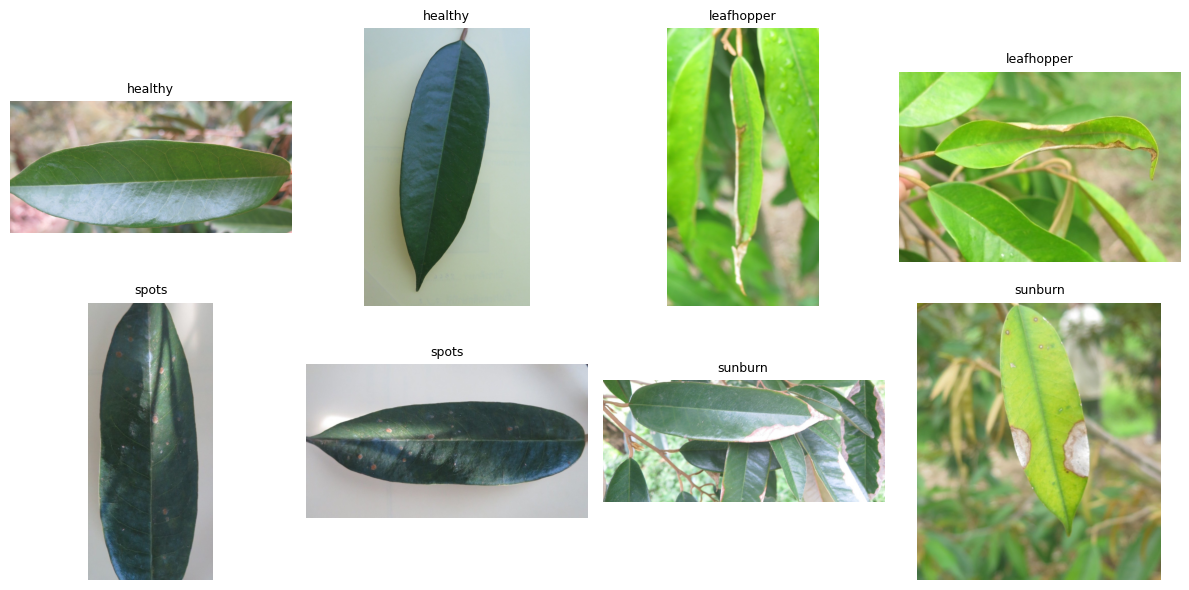

In [7]:
#@title ขั้นตอนที่ 3: ตรวจสอบข้อมูลเบื้องต้น (EDA) — นับจำนวนรูป/คลาส + แกลเลอรีตัวอย่าง
IMG_EXTS = {'.jpg','.jpeg','.png','.bmp','.gif','.tif','.tiff'}

def count_by_class(root: Path):
    rows = []
    for d in sorted([p for p in root.iterdir() if p.is_dir()]):
        c = sum(1 for f in d.rglob('*') if f.suffix.lower() in IMG_EXTS)
        rows.append({'split': root.name, 'class': d.name, 'count': c})
    return pd.DataFrame(rows)

df = pd.concat([
    count_by_class(BASE/'train'),
    count_by_class(BASE/'test_1'),
    count_by_class(BASE/'test_2'),
], ignore_index=True)
display(df)

def gallery(root: Path, max_total=12):
    files = []
    for cls in sorted([p for p in root.iterdir() if p.is_dir()]):
        imgs = [f for f in cls.rglob('*') if f.suffix.lower() in IMG_EXTS]
        if not imgs: continue
        for f in random.sample(imgs, min(2, len(imgs))):
            files.append((cls.name, f))
    files = files[:max_total]
    cols = 4; rows = (len(files) + cols - 1)//cols
    plt.figure(figsize=(cols*3, rows*3))
    for i, (label, fp) in enumerate(files):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(Image.open(fp).convert('RGB'))
        ax.set_title(label, fontsize=9)
        ax.axis('off')
    plt.tight_layout(); plt.show()

gallery(BASE/'train')


In [8]:
#@title ขั้นตอนที่ 4: การตั้งค่าการฝึกและเตรียมข้อมูล (Config + Datasets/DataLoaders) — Balancing & Augmentation + Progress Bar

check_done("B2_data_ready")

!pip -q install tqdm || true
from tqdm.auto import tqdm

IMG_SIZE  = 384   #@param {type:"integer"}  # ลดเหลือ 224 ให้เทรนไวขึ้น (ปรับได้)
BATCH     = 32    #@param {type:"integer"}
EPOCHS    = 50    #@param {type:"integer"}
LR        = 3e-4  #@param {type:"number"}
VAL_SPLIT = 0.1   #@param {type:"number"}
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
CAP       = 0     #@param {type:"integer"}  # 0 = ไม่จำกัด

USE_SAMPLER       = True   #@param {type:"boolean"}
USE_CLASS_WEIGHTS = False  #@param {type:"boolean"}
MIXUP     = True           #@param {type:"boolean"}
CUTMIX    = True           #@param {type:"boolean"}
MIX_ALPHA = 0.4            #@param {type:"number"}

# เร่งความเร็ว kernel / matmul (ถ้าใช้ PyTorch 2.x)
torch.backends.cudnn.benchmark = True
try:
    torch.set_float32_matmul_precision('high')
except Exception:
    pass

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Augmentation (ปรับให้พอดีกับทรัพยากร)
train_tfms = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),  # เปิดถ้าอยากเพิ่ม (จะช้าขึ้นหน่อย)
    T.ColorJitter(0.25,0.25,0.25,0.05),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
test_tfms = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor()])

# โหลดชุด train
full_train = torchvision.datasets.ImageFolder(BASE/'train', transform=train_tfms)
num_classes = len(full_train.classes)

# CAP แบบ stratified (ถ้าต้องการให้เทรนไว)
if CAP and CAP < len(full_train):
    tqdm.write(f"Applying CAP (stratified) to {CAP} samples...")
    targets = [y for _, y in tqdm(full_train, desc="Collect labels for CAP", leave=False)]
    from collections import defaultdict as dd
    by_c = dd(list)
    for i, y in enumerate(tqdm(targets, desc="Group by class", leave=False)):
        by_c[y].append(i)
    per_c = max(1, CAP // max(1, num_classes))
    idxs = []
    for y, arr in tqdm(by_c.items(), desc="Pick per-class indices", leave=False):
        random.shuffle(arr); idxs += arr[:per_c]
    from torch.utils.data import Subset
    full_train = Subset(full_train, idxs)

# Split train/val
val_len   = int(len(full_train) * VAL_SPLIT)
train_len = len(full_train) - val_len
train_ds, val_ds = random_split(
    full_train, [train_len, val_len],
    generator=torch.Generator().manual_seed(SEED)
)

# ----- ดึง labels ของ train_ds พร้อม progress bar -----
def get_labels_from_split(split_ds):
    labels = []
    # case underlying is ImageFolder
    if isinstance(split_ds.dataset, torchvision.datasets.ImageFolder):
        it = tqdm(split_ds.indices, desc="Extract labels (ImageFolder)", leave=False)
        for idx in it:
            _, y = split_ds.dataset[idx]
            labels.append(y)
    else:
        # underlying is Subset(ImageFolder) → RandomSplit(Subset(...))
        base = split_ds.dataset.dataset
        it = tqdm(split_ds.indices, desc="Extract labels (Subset)", leave=False)
        for idx in it:
            real_idx = split_ds.dataset.indices[idx]
            _, y = base[real_idx]
            labels.append(y)
    return labels

train_targets = get_labels_from_split(train_ds)

# คำนวณ class_count / class_weights พร้อม progress (บันทึกเฉย ๆ; bincount เร็วอยู่แล้ว)
class_count = np.bincount(train_targets, minlength=num_classes)
tqdm.write(f"class_count: {class_count.tolist()}")

class_weights_np = 1.0 / np.maximum(class_count, 1)
if USE_CLASS_WEIGHTS:
    tqdm.write("Using class weights for loss.")

# ----- สร้าง DataLoaders พร้อมปรับประสิทธิภาพ -----
num_workers = 2       # ปรับตาม runtime (T4/V100 ลอง 4–8)
prefetch    = 2

if USE_SAMPLER:
    sample_weights = [class_weights_np[y] for y in tqdm(train_targets, desc="Build sample weights", leave=False)]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    train_dl = DataLoader(
        train_ds, batch_size=BATCH, sampler=sampler,
        num_workers=num_workers, pin_memory=True,
        persistent_workers=True, prefetch_factor=prefetch
    )
else:
    train_dl = DataLoader(
        train_ds, batch_size=BATCH, shuffle=True,
        num_workers=num_workers, pin_memory=True,
        persistent_workers=True, prefetch_factor=prefetch
    )

val_dl = DataLoader(
    val_ds, batch_size=BATCH, shuffle=False,
    num_workers=num_workers, pin_memory=True,
    persistent_workers=True, prefetch_factor=prefetch
)

# ยืนยันว่าตัวแปรสำคัญมีจริงก่อนจะ mark
require_vars("train_dl", "val_dl")
# (ถ้าต้องการเข้มขึ้น ให้เช็กโฟลเดอร์ด้วย)
from pathlib import Path
assert (BASE/'train').exists(),   "ยังไม่มีโฟลเดอร์ train"
assert (BASE/'test_1').exists(), "ยังไม่มีโฟลเดอร์ test_1"
assert (BASE/'test_2').exists(), "ยังไม่มีโฟลเดอร์ test_2"

mark_done("B4_dataloaders_ready")



Extract labels (ImageFolder):   0%|          | 0/3600 [00:00<?, ?it/s]

class_count: [885, 908, 912, 895]


Build sample weights:   0%|          | 0/3600 [00:00<?, ?it/s]

[done] B4_dataloaders_ready ✓   all_done = ['B2_data_ready', 'B4_dataloaders_ready']


In [10]:
# ตรวจว่า train/val มีไฟล์ภาพซ้ำ (data leakage) หรือไม่
import torch, torchvision
from torch.utils.data import Subset

def _unwrap_to_imagefolder(ds):
    idx = None
    base = ds
    # คลี่ RandomSplit/Subset ซ้อน ๆ จนเจอ ImageFolder
    while hasattr(base, 'dataset'):
        if isinstance(base, Subset):
            idx = base.indices if idx is None else [base.indices[i] for i in idx]
        base = base.dataset
    assert isinstance(base, torchvision.datasets.ImageFolder), "ฐานข้อมูลไม่ใช่ ImageFolder"
    if idx is None:
        idx = list(range(len(base.samples)))
    return base, idx

base_tr, idx_tr = _unwrap_to_imagefolder(train_dl.dataset)
base_va, idx_va = _unwrap_to_imagefolder(val_dl.dataset)

paths_tr = {base_tr.samples[i][0] for i in idx_tr}
paths_va = {base_va.samples[i][0] for i in idx_va}
overlap = paths_tr & paths_va

print(f"Train size = {len(paths_tr)} | Val size = {len(paths_va)} | Overlap = {len(overlap)}")
if overlap:
    print("ตัวอย่างไฟล์ซ้ำ (แสดงไม่เกิน 10):")
    for p in list(sorted(overlap))[:10]:
        print(" -", p)
    # ถ้าต้องการให้หยุดทันที (กันรั่ว) ให้เปิด assert ด้านล่าง
    # assert False, "พบไฟล์ซ้ำระหว่าง train และ val"
    # rebuild val_dl ให้ใช้ test_tfms (ไม่มี augmentation)
val_base_det = torchvision.datasets.ImageFolder(BASE/'train', transform=test_tfms)
val_ds_det   = Subset(val_base_det, idx_va)
val_dl       = DataLoader(val_ds_det, batch_size=BATCH, shuffle=False,
                          num_workers=2, pin_memory=True)
print("Rebuilt val_dl with test_tfms (no augmentation).")


Train size = 3600 | Val size = 400 | Overlap = 0
Rebuilt val_dl with test_tfms (no augmentation).


In [11]:
#@title ขั้นตอนที่ 5: สร้างโมเดลและตัวช่วย (Model + LR Scheduler + MixUp/CutMix)

check_done("B4_dataloaders_ready")
require_vars("num_classes", "train_dl", "val_dl", "device")

!pip -q install timm
import timm

!pip -q install --no-deps tqdm || true  # เผื่อยังไม่ได้ติดตั้งจากบล็อก 4
import math
from tqdm.auto import tqdm

# โมเดล: ResNet18 (pretrained) — เปลี่ยน head ให้ตรงจำนวนคลาส
#model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
#model.fc = nn.Linear(model.fc.in_features, num_classes)
#model = model.to(device)

# โมเดล: EfficientNet-B0 (แนะนำสำหรับลายละเอียดจุด ๆ)
model = timm.create_model(
    'efficientnet_b0',
    pretrained=True,
    num_classes=num_classes,
    drop_rate=0.2,             # dropout นิดหน่อยช่วย generalize
).to(device)

# (ออปชัน) ใช้ memory format เพื่อความเร็วบน GPU รุ่นใหม่
try:
    model = model.to(memory_format=torch.channels_last)
except Exception:
    pass


# ช่วยปรับประสิทธิภาพ
torch.backends.cudnn.benchmark = True
try:
    torch.set_float32_matmul_precision('high')  # PyTorch 2.x
except Exception:
    pass

# Define weights_tensor based on USE_CLASS_WEIGHTS and class_weights_np
# class_weights_np is calculated in cell 0Y_CUTUrWCzX
weights_tensor = None
if globals().get('USE_CLASS_WEIGHTS', False) and 'class_weights_np' in globals():
    weights_tensor = torch.tensor(globals()['class_weights_np'], dtype=torch.float32)


# Loss/Optim/Scheduler
criterion = nn.CrossEntropyLoss(
    weight=weights_tensor.to(device) if weights_tensor is not None else None
)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

# MixUp / CutMix helpers
def mixup_data(x, y, alpha):
    if alpha <= 0: return x, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    return lam * x + (1 - lam) * x[idx], (y, y[idx]), lam

def cutmix_data(x, y, alpha):
    if alpha <= 0: return x, y, 1.0
    lam = np.random.beta(alpha, alpha)
    B, C, H, W = x.size()
    idx = torch.randperm(B, device=x.device)
    cx, cy = np.random.randint(W), np.random.randint(H)
    w = int(W * math.sqrt(1 - lam))
    h = int(H * math.sqrt(1 - lam))
    x1 = max(cx - w // 2, 0); x2 = min(cx + w // 2, W)
    y1 = max(cy - h // 2, 0); y2 = min(cy + h // 2, H)
    x[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
    lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H + 1e-8))
    return x, (y, y[idx]), lam

def mix_criterion(crit, pred, targets, lam):
    y_a, y_b = targets
    return lam * crit(pred, y_a) + (1 - lam) * crit(pred, y_b)

print("Model ready → classes:", num_classes)

mark_done("B5_model_ready")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Model ready → classes: 4
[done] B5_model_ready ✓   all_done = ['B2_data_ready', 'B4_dataloaders_ready', 'B5_model_ready']


Epoch 1/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 1/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 001 | train_loss=1.1284  val_loss=1.1498  val_acc=0.4625


Epoch 2/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 2/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 002 | train_loss=0.7250  val_loss=1.3295  val_acc=0.4450


Epoch 3/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 3/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 003 | train_loss=0.5393  val_loss=1.2455  val_acc=0.4400


Epoch 4/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 4/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 004 | train_loss=0.5612  val_loss=0.6870  val_acc=0.7000


Epoch 5/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 5/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 005 | train_loss=0.5330  val_loss=1.4735  val_acc=0.4125


Epoch 6/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 6/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 006 | train_loss=0.4652  val_loss=0.5293  val_acc=0.8150


Epoch 7/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 7/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 007 | train_loss=0.5378  val_loss=0.3532  val_acc=0.9175


Epoch 8/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 8/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 008 | train_loss=0.5207  val_loss=0.3646  val_acc=0.9200


Epoch 9/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 9/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 009 | train_loss=0.4422  val_loss=0.2559  val_acc=0.9325


Epoch 10/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 10/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 010 | train_loss=0.4725  val_loss=0.3126  val_acc=0.9375


Epoch 11/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 11/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 011 | train_loss=0.5158  val_loss=0.3082  val_acc=0.9100


Epoch 12/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 12/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 012 | train_loss=0.4477  val_loss=0.2259  val_acc=0.9525


Epoch 13/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 13/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 013 | train_loss=0.4588  val_loss=0.2049  val_acc=0.9600


Epoch 14/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 14/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 014 | train_loss=0.4496  val_loss=0.2809  val_acc=0.9100


Epoch 15/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 15/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 015 | train_loss=0.4213  val_loss=0.2900  val_acc=0.9250


Epoch 16/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 16/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 016 | train_loss=0.4591  val_loss=0.2239  val_acc=0.9350


Epoch 17/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 17/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 017 | train_loss=0.4854  val_loss=0.2435  val_acc=0.9375


Epoch 18/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 18/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 018 | train_loss=0.4415  val_loss=0.1909  val_acc=0.9550


Epoch 19/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 19/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 019 | train_loss=0.4437  val_loss=0.1403  val_acc=0.9900


Epoch 20/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 20/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 020 | train_loss=0.4086  val_loss=0.1491  val_acc=0.9775


Epoch 21/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 21/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 021 | train_loss=0.3651  val_loss=0.1329  val_acc=0.9900


Epoch 22/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 22/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 022 | train_loss=0.3958  val_loss=0.2357  val_acc=0.9300


Epoch 23/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 23/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 023 | train_loss=0.4186  val_loss=0.1536  val_acc=0.9975


Epoch 24/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 24/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 024 | train_loss=0.4166  val_loss=0.1578  val_acc=0.9725


Epoch 25/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 25/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 025 | train_loss=0.4050  val_loss=0.1319  val_acc=0.9675


Epoch 26/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 26/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 026 | train_loss=0.3686  val_loss=0.1249  val_acc=0.9750


Epoch 27/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 27/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 027 | train_loss=0.3727  val_loss=0.1257  val_acc=0.9925


Epoch 28/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 28/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 028 | train_loss=0.4010  val_loss=0.1157  val_acc=0.9975


Epoch 29/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 29/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 029 | train_loss=0.4048  val_loss=0.1382  val_acc=0.9600


Epoch 30/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 30/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 030 | train_loss=0.3849  val_loss=0.1495  val_acc=0.9825


Epoch 31/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 31/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 031 | train_loss=0.4023  val_loss=0.1195  val_acc=0.9750


Epoch 32/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 32/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 032 | train_loss=0.4056  val_loss=0.1374  val_acc=0.9825


Epoch 33/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 33/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 033 | train_loss=0.3992  val_loss=0.1309  val_acc=0.9900


Epoch 34/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 34/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 034 | train_loss=0.3831  val_loss=0.1151  val_acc=0.9925


Epoch 35/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 35/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 035 | train_loss=0.3781  val_loss=0.1355  val_acc=0.9900


Epoch 36/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 36/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 036 | train_loss=0.3725  val_loss=0.1626  val_acc=0.9725


Epoch 37/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 37/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 037 | train_loss=0.4215  val_loss=0.1494  val_acc=0.9725


Epoch 38/50 [train]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 38/50 [val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 038 | train_loss=0.3897  val_loss=0.1361  val_acc=0.9700
Early stopping.


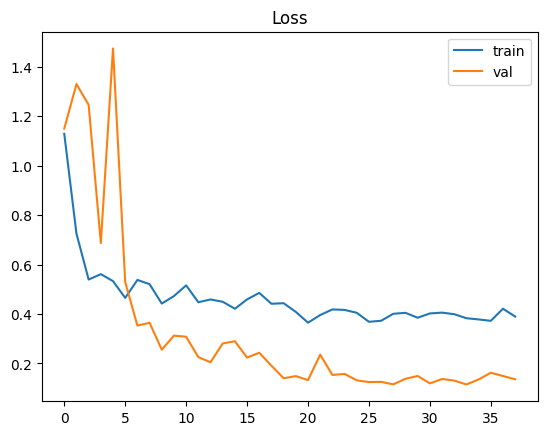

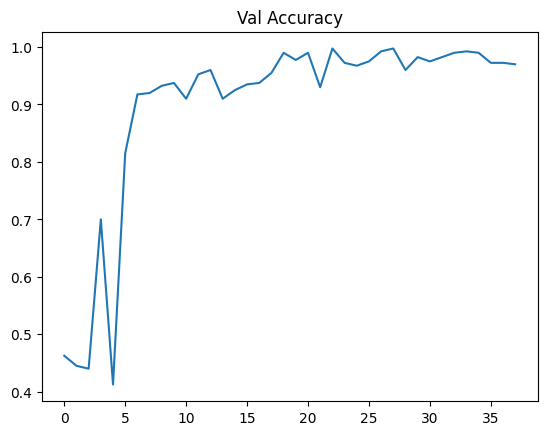

In [12]:
#@title ขั้นตอนที่ 6: ฝึกโมเดล (Train) — Single Cell: Safety Net + AMP (auto) + tqdm + Early Stopping + Curves

check_done("B4_dataloaders_ready")
require_vars("num_classes", "train_dl", "val_dl", "device")


# ติดตั้ง tqdm (ถ้ายังไม่มี)
!pip -q install tqdm || true

# ===== Imports ที่ใช้ในเซลล์นี้ =====
import math, numpy as np, torch, torchvision
from pathlib import Path
from contextlib import nullcontext
from tqdm.auto import tqdm
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import transforms as T, models
# ---- AMP setup (version-robust, no warnings) ----
from contextlib import nullcontext  # ถ้าด้านบน import แล้ว ข้ามบรรทัดนี้ได้
import torch

has_torch_amp = hasattr(torch, "amp") and hasattr(torch.amp, "autocast")
use_cuda = torch.cuda.is_available()

if use_cuda and has_torch_amp:
    autocast = lambda: torch.amp.autocast('cuda')
    scaler  = torch.amp.GradScaler('cuda')
elif use_cuda:
    # fallback สำหรับ PyTorch รุ่นเก่าที่มี torch.cuda.amp
    from torch.cuda.amp import autocast as _autocast, GradScaler as _GradScaler
    autocast = lambda: _autocast()
    scaler  = _GradScaler(enabled=True)
else:
    # CPU: ปิด AMP
    autocast = lambda: nullcontext()
    scaler  = None
try:
    import matplotlib.pyplot as plt
except Exception:
    pass  # ถ้าบล็อก 1 มี import แล้วก็เพียงพอ

# ========= SAFETY NET: สร้างตัวแปร/ออบเจ็กต์ที่จำเป็นถ้ายังไม่มี =========
# ค่าเริ่มต้น (กรณีรันเซลล์นี้เดี่ยว ๆ)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BASE = globals().get('BASE', Path('durian_leaf_pro'))
SEED = globals().get('SEED', 42)
IMG_SIZE = globals().get('IMG_SIZE', 384)
BATCH = globals().get('BATCH', 32)
LR = globals().get('LR', 3e-4)
VAL_SPLIT = globals().get('VAL_SPLIT', 0.1)
MIXUP = globals().get('MIXUP', True)
CUTMIX = globals().get('CUTMIX', True)
MIX_ALPHA = globals().get('MIX_ALPHA', 0.4)

# ถ้าไม่มี train_dl/val_dl ให้สร้างแบบย่อ
def _build_basic_dataloaders():
    train_tfms = T.Compose([
        T.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
    ])
    test_tfms  = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor()])
    ds_full = torchvision.datasets.ImageFolder(BASE/'train', transform=train_tfms)
    num_classes = len(ds_full.classes)
    val_len  = int(len(ds_full)*VAL_SPLIT)
    train_len = len(ds_full) - val_len
    train_ds, val_ds = random_split(ds_full, [train_len, val_len],
                                    generator=torch.Generator().manual_seed(SEED))
    # Set num_workers to 0 for debugging
    train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=True)
    val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
    return train_dl, val_dl, num_classes, ds_full.classes

if 'train_dl' not in globals() or 'val_dl' not in globals():
    print("[setup] building dataloaders...")
    train_dl, val_dl, _num_classes, _classes = _build_basic_dataloaders()

# เดาจำนวนคลาสถ้ายังไม่มี
if 'num_classes' not in globals():
    if hasattr(train_dl.dataset, "dataset") and hasattr(train_dl.dataset.dataset, "classes"):
        num_classes = len(train_dl.dataset.dataset.classes)
    else:
        classes_fs = sorted([p.name for p in (BASE/'train').iterdir() if p.is_dir()])
        num_classes = len(classes_fs)

if 'model' not in globals():
    print(f"[setup] creating EfficientNet-B0 with {num_classes} classes...")
    import timm  # เผื่อบล็อก 6 รันเดี่ยว ๆ
    model = timm.create_model('efficientnet_b0', pretrained=True,
                              num_classes=num_classes, drop_rate=0.2).to(device)
    try: model = model.to(memory_format=torch.channels_last)
    except: pass


if 'criterion' not in globals():
    criterion = nn.CrossEntropyLoss()

if 'optimizer' not in globals():
    optimizer = optim.Adam(model.parameters(), lr=LR)

if 'scheduler' not in globals():
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# กำหนดจำนวนรอบฝึก (fallback ถ้าไม่ได้กำหนดไว้)
EPOCHS = globals().get('EPOCHS', 10)

# ========= Utilities: MixUp / CutMix / mix_criterion =========
def mixup_data(x, y, alpha):
    if alpha <= 0: return x, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    return lam * x + (1 - lam) * x[idx], (y, y[idx]), lam

def cutmix_data(x, y, alpha):
    if alpha <= 0: return x, y, 1.0
    lam = np.random.beta(alpha, alpha)
    B, C, H, W = x.size()
    idx = torch.randperm(B, device=x.device)
    cx, cy = np.random.randint(W), np.random.randint(H)
    w = int(W * math.sqrt(1 - lam)); h = int(H * math.sqrt(1 - lam))
    x1 = max(cx - w // 2, 0); x2 = min(cx + w // 2, W)
    y1 = max(cy - h // 2, 0); y2 = min(cy + h // 2, H)
    x[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
    lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H + 1e-8))
    return x, (y, y[idx]), lam

def mix_criterion(crit, pred, targets, lam):
    y_a, y_b = targets
    return lam * crit(pred, y_a) + (1 - lam) * crit(pred, y_b)

# ========= AMP setup (ปรับอัตโนมัติ: ใช้เมื่อมี CUDA เท่านั้น) =========
#use_amp = torch.cuda.is_available() and hasattr(torch.cuda, "amp")
#autocast = torch.cuda.amp.autocast if use_amp else (lambda **kw: nullcontext())
#scaler = torch.cuda.amp.GradScaler(enabled=True) if use_amp else None

# ========= Train Loop (พร้อม tqdm + Early Stopping) =========
def get_lr(optim): return optim.param_groups[0]['lr']

best_val = float('inf'); patience = 10; bad = 0
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

# ==== Resume if last checkpoint exists (ข้อ 2 ก) ====
from pathlib import Path

# ใช้โฟลเดอร์ใน Google Drive ถ้าคุณตั้ง CKPT_DIR ไว้แล้ว; ถ้าไม่มีก็ใช้โลคัล 'ckpts'
CKPT_DIR = globals().get('CKPT_DIR', Path('ckpts'))
CKPT_DIR.mkdir(parents=True, exist_ok=True)

last_ckpt = CKPT_DIR/'last.pth'
best_ckpt = CKPT_DIR/'best.pth'

RESUME    = True
min_delta = 1e-3       # ใช้คู่กับ early stopping (อยู่ในข้อ 2 ข)
start_epoch = 1
best_val    = float('inf')  # จะถูก override ถ้ามีในเช็คพอยต์

if RESUME and last_ckpt.exists():
    state = torch.load(last_ckpt, map_location=device)
    # โหลดน้ำหนักโมเดล
    model.load_state_dict(state['state_dict'])
    # โหลด optimizer/scheduler/scaler ถ้ามี
    if 'optimizer' in state: optimizer.load_state_dict(state['optimizer'])
    if 'scheduler' in state: scheduler.load_state_dict(state['scheduler'])
    if scaler is not None and state.get('scaler') is not None:
        scaler.load_state_dict(state['scaler'])
    # กู้ค่า best_val / history / epoch
    best_val    = state.get('best_val', best_val)
    history     = state.get('history', history)
    start_epoch = state.get('epoch', 0) + 1
    tqdm.write(f"[resume] continue from epoch {start_epoch} (best_val={best_val:.4f})")

for ep in range(start_epoch, EPOCHS + 1):
    # ---- Train ----
    model.train(); running = 0.0
    pbar = tqdm(train_dl, desc=f"Epoch {ep}/{EPOCHS} [train]", leave=False)
    for xb, yb in pbar:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        try: xb = xb.to(memory_format=torch.channels_last)
        except Exception: pass

        use_mixup = MIXUP and (not CUTMIX or np.random.rand() < 0.5)
        use_cutmix = CUTMIX and not use_mixup

        optimizer.zero_grad(set_to_none=True)
        with autocast():
            if use_mixup:
                mx, (ya, yb2), lam = mixup_data(xb, yb, MIX_ALPHA)
                out = model(mx)
                loss = mix_criterion(criterion, out, (ya, yb2), lam)
            elif use_cutmix:
                cx, (ya, yb2), lam = cutmix_data(xb.clone(), yb, MIX_ALPHA)
                out = model(cx)
                loss = mix_criterion(criterion, out, (ya, yb2), lam)
            else:
                out = model(xb)
                loss = criterion(out, yb)

        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running += loss.item() * xb.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{get_lr(optimizer):.2e}")

    tr_loss = running / len(train_dl.dataset)

    # ---- Validate ----
    model.eval(); va_loss = 0.0; correct = 0; n = 0
    pbar_val = tqdm(val_dl, desc=f"Epoch {ep}/{EPOCHS} [val]", leave=False)
    with torch.no_grad(), autocast():
        for xb, yb in pbar_val:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            try: xb = xb.to(memory_format=torch.channels_last)
            except Exception: pass

            out = model(xb)
            l = criterion(out, yb)
            va_loss += l.item() * xb.size(0)
            pred = out.argmax(1)
            correct += (pred == yb).sum().item()
            n += xb.size(0)
            pbar_val.set_postfix(val_loss=f"{l.item():.4f}")

    va_loss = va_loss / (n or 1)
    va_acc  = correct / (n or 1)
    history['train_loss'].append(tr_loss)
    history['val_loss'].append(va_loss)
    history['val_acc'].append(va_acc)

    tqdm.write(f"Epoch {ep:03d} | train_loss={tr_loss:.4f}  val_loss={va_loss:.4f}  val_acc={va_acc:.4f}")
    scheduler.step(va_loss)

        # ==== Autosave (last) + Save best + Early stopping ====
    # เซฟ last ทุก epoch (สำหรับ resume ครั้งหน้า)
    torch.save({
        'epoch': ep,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'scaler': (scaler.state_dict() if scaler is not None else None),
        'best_val': best_val,
        'history': history,
        'classes': torchvision.datasets.ImageFolder(BASE/'train').classes,
        'img_size': IMG_SIZE,
        'arch': 'efficientnet_b0',   # ปรับชื่อให้ตรงสถาปัตยกรรมที่ใช้
    }, last_ckpt)

    # เซฟ best เมื่อ val_loss ดีขึ้นอย่างมีนัย (min_delta)
    if va_loss < best_val - min_delta:
        best_val = va_loss; bad = 0
        torch.save({
            'epoch': ep,
            'state_dict': model.state_dict(),
            'best_val': best_val,
            'classes': torchvision.datasets.ImageFolder(BASE/'train').classes,
            'img_size': IMG_SIZE,
            'arch': 'efficientnet_b0',
        }, best_ckpt)
        # (ออปชัน) คงไฟล์เก่าเดิมไว้ให้บล็อก 7 ใช้ได้เหมือนเดิม
        torch.save({
            'state_dict': model.state_dict(),
            'classes': torchvision.datasets.ImageFolder(BASE/'train').classes,
            'img_size': IMG_SIZE
        }, 'durian_resnet18_pro.pt')
        tqdm.write(f"[best] saved at epoch {ep}  best_val={best_val:.4f}")
    else:
        bad += 1
        if bad >= patience:
            tqdm.write('Early stopping.')
            break


# ========= Learning curves =========
try:
    plt.figure(); plt.plot(history['train_loss'], label='train'); plt.plot(history['val_loss'], label='val')
    plt.title('Loss'); plt.legend(); plt.show()

    plt.figure(); plt.plot(history['val_acc'])
    plt.title('Val Accuracy'); plt.show()
except Exception as e:
    print("Plot skipped:", e)

In [ ]:
#@title ขั้นตอนที่ 7: ประเมินผล (Evaluate) รายงานรายคลาส + กราฟ + Confusion Matrix

import torch, torchvision, numpy as np, pandas as pd
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms as T, models
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- โหลดเช็คพอยต์ + คลาส (เลือก best.pth จาก Drive ถ้ามี) ---
from pathlib import Path

CKPT_DIR = globals().get('CKPT_DIR', Path('ckpts'))  # ถ้าบล็อก 6 ตั้ง CKPT_DIR ไว้จะดึงมาใช้
best_ckpt = CKPT_DIR/'best.pth'

ckpt_path = best_ckpt if best_ckpt.exists() else Path('durian_resnet18_pro.pt')
print(f"[eval] loading checkpoint from: {ckpt_path}")
ckpt = torch.load(ckpt_path, map_location='cpu')

classes  = ckpt['classes']
IMG_EVAL = ckpt.get('img_size', 384)
arch     = ckpt.get('arch', 'resnet18')   # 'efficientnet_b0' หรือ 'resnet18'


# --- สร้างโมเดลสำหรับประเมิน ตาม arch ที่บันทึกมา ---
if arch == 'efficientnet_b0':
    import timm
    eval_model = timm.create_model('efficientnet_b0', pretrained=False,
                                   num_classes=len(classes))
else:
    eval_model = models.resnet18(weights=None)
    eval_model.fc = nn.Linear(eval_model.fc.in_features, len(classes))

eval_model.load_state_dict(ckpt['state_dict'])
eval_model.to(device).eval()


# --- ใช้ Normalize แบบเดียวกับตอนเทรน ---
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
eval_tfms = T.Compose([
    T.Resize((IMG_EVAL, IMG_EVAL)),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

def eval_split(split_name):
    root = BASE / split_name
    ds = torchvision.datasets.ImageFolder(root, transform=eval_tfms)
    dl = DataLoader(ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
    preds, labels = [], []
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(device)
            out = eval_model(xb)
            preds.extend(out.argmax(1).cpu().numpy().tolist())
            labels.extend(yb.numpy().tolist())
    return np.array(labels), np.array(preds), ds.classes

def plot_confusion_and_bars(y, p, split_name):

    # Confusion Matrix (count & normalized)
    cm = confusion_matrix(y, p, labels=list(range(len(classes))))
    cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    im0 = axes[0].imshow(cm, aspect='auto')
    axes[0].set_title(f'Confusion Matrix — {split_name} (count)')
    axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')
    axes[0].set_xticks(range(len(classes))); axes[0].set_xticklabels(classes, rotation=45, ha='right')
    axes[0].set_yticks(range(len(classes))); axes[0].set_yticklabels(classes)
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(cm_norm, vmin=0, vmax=1, aspect='auto')
    axes[1].set_title(f'Confusion Matrix — {split_name} (normalized)')
    axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
    axes[1].set_xticks(range(len(classes))); axes[1].set_xticklabels(classes, rotation=45, ha='right')
    axes[1].set_yticks(range(len(classes))); axes[1].set_yticklabels(classes)
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.savefig(f'cm_{split_name}.png', dpi=150)
    plt.show()

    # Bar chart: precision / recall / f1 ต่อคลาส
    pr, rc, f1, sup = precision_recall_fscore_support(y, p, labels=list(range(len(classes))), zero_division=0)
    x = np.arange(len(classes))
    width = 0.27
    plt.figure(figsize=(12, 4))
    plt.bar(x - width, pr, width, label='precision')
    plt.bar(x,         rc, width, label='recall')
    plt.bar(x + width, f1, width, label='f1')
    plt.xticks(x, classes, rotation=45, ha='right')
    plt.ylim(0, 1.05)
    plt.title(f'Per-class Metrics — {split_name}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'per_class_metrics_{split_name}.png', dpi=150)
    plt.show()

    # บันทึก CSV confusion matrix (เหมือนเดิม)
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    df_cm.to_csv(f'confusion_matrix_{split_name}.csv', index=True)

for name in ['test_1', 'test_2']:
    y, p, _ = eval_split(name)
    if len(y) == 0:
        print(name, 'is empty'); continue

    acc = float((y == p).mean())
    print(f"\n=== {name} ===")
    print('Accuracy:', round(acc, 4), 'N:', len(y))
    print('\nPer-class report:')
    from sklearn.metrics import classification_report
    print(classification_report(y, p, target_names=classes, digits=4, zero_division=0))

    # วาดกราฟ + บันทึกไฟล์
    plot_confusion_and_bars(y, p, name)
    print(f"Saved: confusion_matrix_{name}.csv, cm_{name}.png, per_class_metrics_{name}.png")


In [20]:
#@title ขั้นตอนที่ 8: บันทึกไฟล์โมเดลและผลลัพธ์ (Artifacts & Download)
from zipfile import ZipFile, ZIP_DEFLATED

ARTS = [
    'durian_resnet18_pro.pt',
    'confusion_matrix_test_1.csv',
    'confusion_matrix_test_2.csv',
]

bundle = Path('durian_leaf_artifacts.zip')
with ZipFile(bundle, 'w', ZIP_DEFLATED) as z:
    for p in ARTS:
        if Path(p).exists():
            z.write(p)

print('Bundled:', bundle)

# ดาวน์โหลดอัตโนมัติเมื่อรันบน Google Colab
try:
    from google.colab import files
    files.download(str(bundle))
except Exception as e:
    print('เปิดใน Colab ถึงจะดาวน์โหลดอัตโนมัติได้:', e)


Bundled: durian_leaf_artifacts.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>